# How Much Has COVID-19 Slowed Census Enumeration In Rural Areas?
### By Benjamin Livingston, *[NewsCounts](https://newscounts.org/)*
### May 21, 2020

73.3% of tracts with response rate data also have enumeration strategy logged and will be a part of this analysis


,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.52
Tracts Relying On In-Person Census Operations For Initial Contact,-0.52


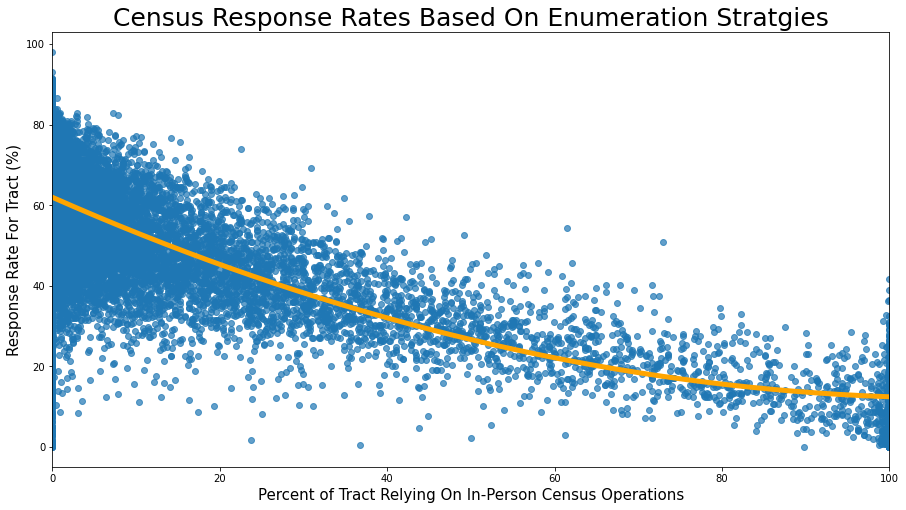

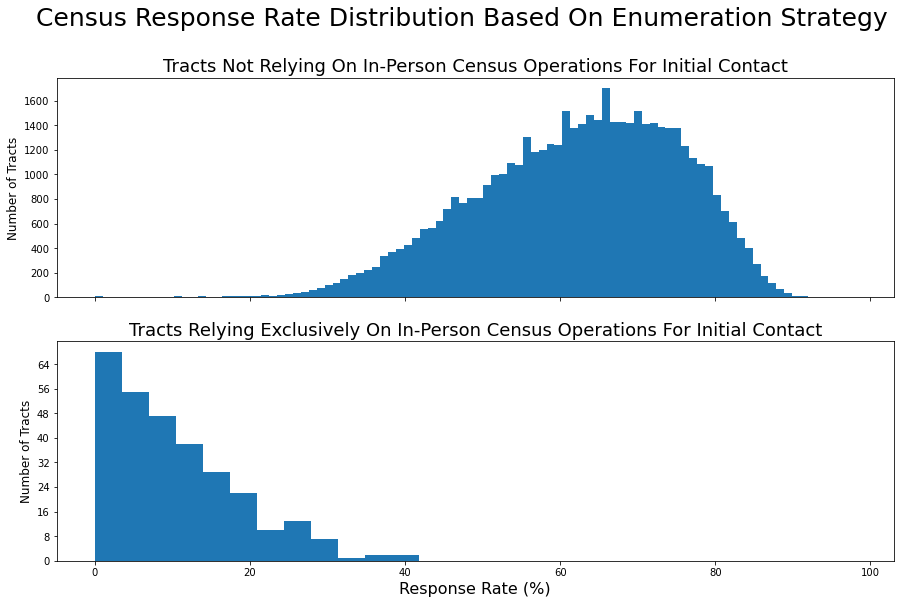

In [1]:
# import packages
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import warnings
from matplotlib.ticker import MaxNLocator
%matplotlib inline
warnings.filterwarnings('ignore')

# set API key 
key = '2988f01f5e86175bda8beae2b5035e1ccef2d052'

# tested shortcut for obtaining state FIPS codes
url = f"https://api.census.gov/data/2010/dec/responserate?get=GEO_ID,FSRR2010&key={key}&for=state:*"
JSONContent = requests.get(url).json()
states = pd.DataFrame(JSONContent)
states = states.iloc[1:,2]
states = [int(i) for i in states if i !='72']
states = sorted(states)

# data frame to hold tract responses
tract_responses = pd.DataFrame(columns=['GEO_ID','CRRALL'])

# pull tract response data for 2020
for i in states:
    if i < 10:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:0"\
        + str(i)
    else:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:"\
        + str(i)
    try:
        JSONContent = requests.get(url).json()
        temp = pd.DataFrame(JSONContent).iloc[:,0:2]
        temp.columns = temp.iloc[0]
        temp = temp.iloc[1:,:]
        tract_responses = pd.concat([tract_responses,temp],sort=True)
    except json.JSONDecodeError:
        pass

# set index and column title for 2020 response rates
tract_responses['CRRALL'] = tract_responses['CRRALL'].astype('float')
tract_responses.index = tract_responses.GEO_ID.str.replace('1400000US','')
tract_responses = tract_responses.drop(columns = 'GEO_ID')
tract_responses.columns = ['response']

# pull type of enumeration data
tea = pd.read_excel('https://www2.census.gov/geo/maps/DC2020/TEA/TEA_PCT_Housing_Tract.xlsx')
tea.index = tea.TRACT_GEOID
tea.index.name = 'GEO_ID'
tea.index = tea.index.astype('str').str.zfill(11)
tea['inperson'] = tea.PCT_HU_TEA2 + tea.PCT_HU_TEA4 + tea.PCT_HU_TEA6
tea = tea.drop(columns=['TRACT_GEOID','PCT_HU_TEA2','PCT_HU_TEA3','PCT_HU_TEA4','PCT_HU_TEA6'])
tea.columns=['mail','inperson']

# remove type of enumeration entries with no data
tea = tea[np.sum(tea,axis=1) > 99.5]

# count percentage of tracts in our response dataset for which we have enumeration data
temp = pd.merge(tract_responses,tea,'left','GEO_ID')
print(np.round(100 * np.sum(pd.notnull(temp.mail)) / temp.shape[0],1),'% of tracts with response rate data \
also have enumeration strategy logged and will be a part of this analysis',sep='')

# create dataset
data = pd.merge(tract_responses,tea,'inner','GEO_ID')

# show correlations
corrs = pd.DataFrame(data.corr().iloc[1:,0].round(2))
corrs.columns = ['Correlation With Overall Response Rates']
corrs.index = ['Tracts Not Relying On In-Person Census Operations For Initial Contact',\
       'Tracts Relying On In-Person Census Operations For Initial Contact']
display(corrs)

# make scatterplot of data
plt.figure(figsize=(15,8))
plt.scatter(data.inperson,data.response,alpha=0.7,label='Areas Relying Heavily On In-Person Operations')
plt.plot(np.unique(data.inperson),np.poly1d(np.polyfit(data.inperson,data.response, 2))(np.unique(data.inperson)),\
         c='orange',linewidth=5)
plt.title('Census Response Rates Based On Enumeration Stratgies',size=25)
plt.xlim(0,100)
plt.xlabel('Percent of Tract Relying On In-Person Census Operations',size=15)
plt.ylabel('Response Rate For Tract (%)',size=15)

# make histograms of data
all_mail = data[data.mail > 99.8]
all_inperson = data[data.inperson > 99.8]
fig,ax = plt.subplots(2,1,figsize=(15,9),sharex=True)
plt.xlabel('Response Rate (%)',size=16)
plt.subplots_adjust(top=0.87)
plt.suptitle('Census Response Rate Distribution Based On Enumeration Strategy',size=25)
mai = ax[0]
inp = ax[1]
mai.yaxis.set_major_locator(MaxNLocator(integer=True))
inp.yaxis.set_major_locator(MaxNLocator(integer=True))
mai.set_ylabel('Number of Tracts',size=12)
inp.set_ylabel('Number of Tracts',size=12)
mai.hist(all_mail.response,bins='auto')
inp.hist(all_inperson.response,bins='auto')
mai.set_title('Tracts Not Relying On In-Person Census Operations For Initial Contact',size=18)
inp.set_title('Tracts Relying Exclusively On In-Person Census Operations For Initial Contact',size=18)

# helper function to plot individual areas
def show_area(fips):
    
    # trim newset
    new = data[data.index.str.startswith(str(fips))]
    
    # show correlations
    corrs = pd.DataFrame(new.corr().iloc[1:,0].round(2))
    corrs.columns = ['Correlation With Overall Response Rates']
    corrs.index = ['Tracts Not Relying On In-Person Census Operations For Initial Contact',\
           'Tracts Relying On In-Person Census Operations For Initial Contact']
    display(corrs)

    # make scatterplot of data
    plt.figure(figsize=(15,8))
    plt.scatter(new.inperson,new.response,alpha=0.7,label='Areas Relying Heavily On In-Person Operations')
    plt.plot(np.unique(new.inperson),np.poly1d(np.polyfit(new.inperson,new.response, 2))(np.unique(new.inperson)),\
             c='orange',linewidth=5)
    plt.title('Census Response Rates Based On Enumeration Stratgies',size=25)
    plt.xlim(0,100)
    plt.xlabel('Percent of Tract Relying On In-Person Census Operations',size=15)
    plt.ylabel('Response Rate For Tract (%)',size=15)

    # make histograms of data
    all_mail = new[new.mail > 99.8]
    all_inperson = new[new.inperson > 99.8]
    fig,ax = plt.subplots(2,1,figsize=(15,9),sharex=True)
    plt.xlabel('Response Rate (%)',size=16)
    plt.subplots_adjust(top=0.87)
    plt.suptitle('Census Response Rate Distribution Based On Enumeration Strategy',size=25)
    mai = ax[0]
    inp = ax[1]
    mai.yaxis.set_major_locator(MaxNLocator(integer=True))
    inp.yaxis.set_major_locator(MaxNLocator(integer=True))
    mai.set_ylabel('Number of Tracts',size=12)
    inp.set_ylabel('Number of Tracts',size=12)
    mai.hist(all_mail.response,bins='auto')
    inp.hist(all_inperson.response,bins='auto')
    mai.set_title('Tracts Not Relying On In-Person Census Operations For Initial Contact',size=18)
    inp.set_title('Tracts Relying Exclusively On In-Person Census Operations For Initial Contact',size=18)
    
    # print total number of tracts examined
    print('Total Number of Tracts Examined: ',new.shape[0])

# State Case Studies

Remember - **we can easily do this analysis for your area almost instantaneously** - email me any time at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) if you'd like to see these results for your region, too.

[*NewsCounts*](http://newscounts.org) provides countless data & research resources that make telling these stories easy - just drop us a line and we'll be happy to help.


### New Mexico

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.84
Tracts Relying On In-Person Census Operations For Initial Contact,-0.84


Total Number of Tracts Examined:  405


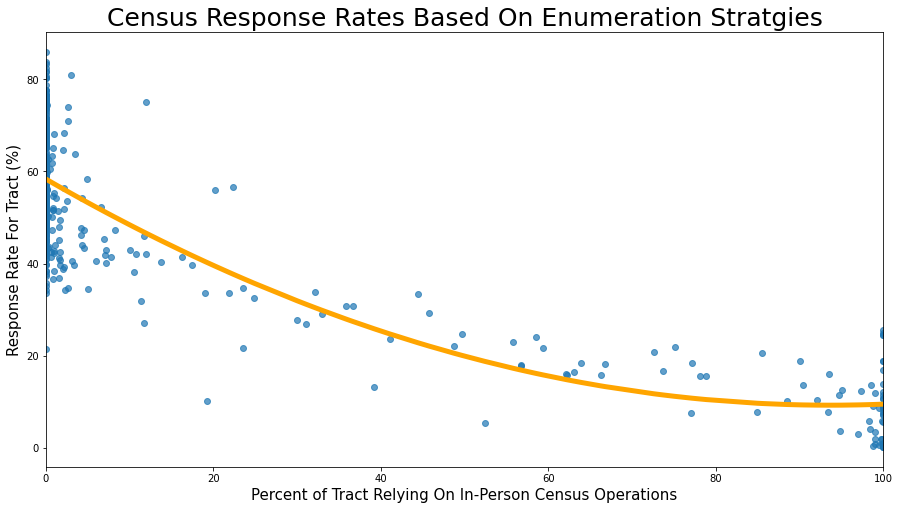

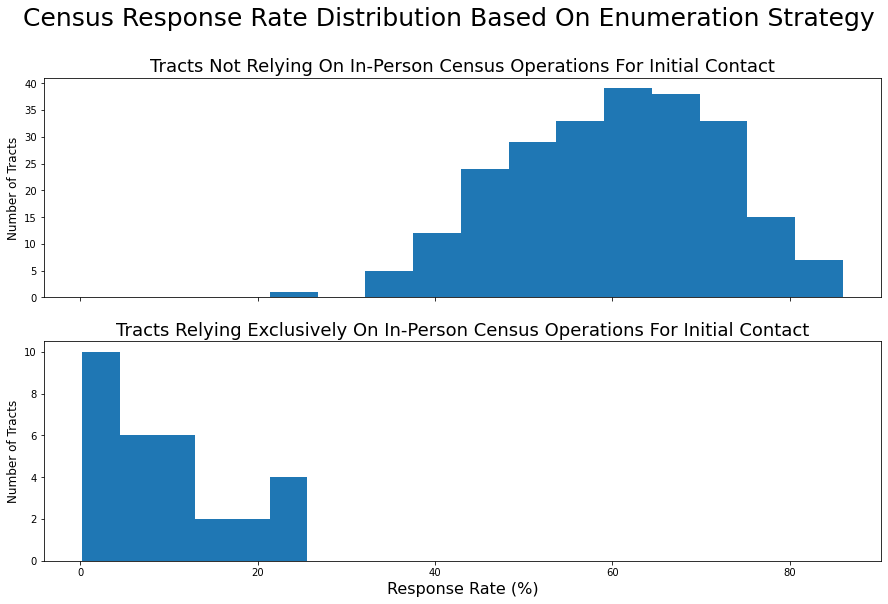

In [2]:
show_area(35)

### Arizona

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.75
Tracts Relying On In-Person Census Operations For Initial Contact,-0.75


Total Number of Tracts Examined:  1296


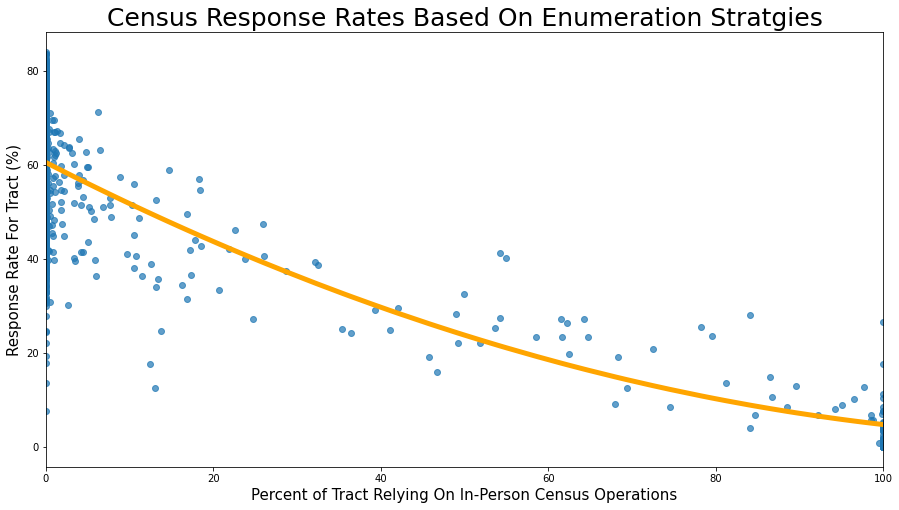

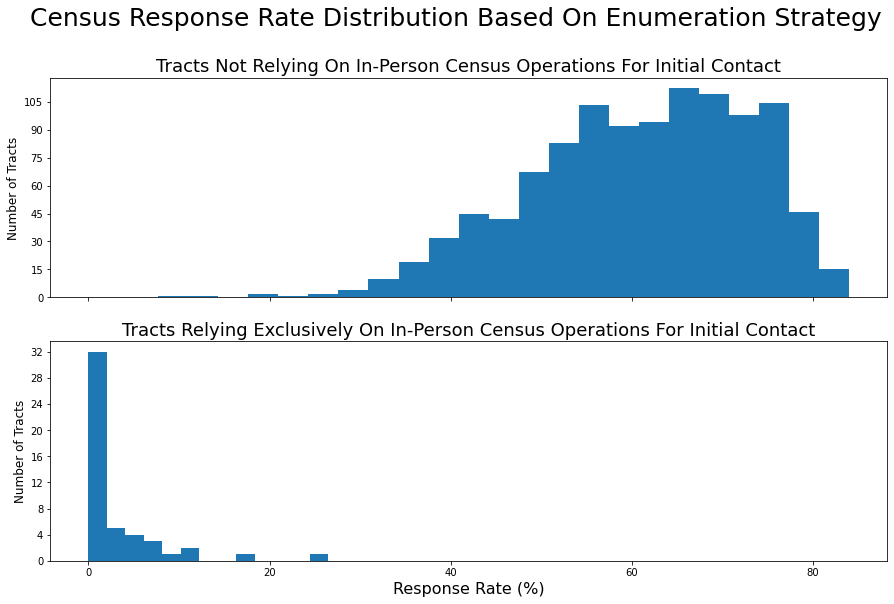

In [3]:
show_area('04')

### Alaska

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.91
Tracts Relying On In-Person Census Operations For Initial Contact,-0.91


Total Number of Tracts Examined:  130


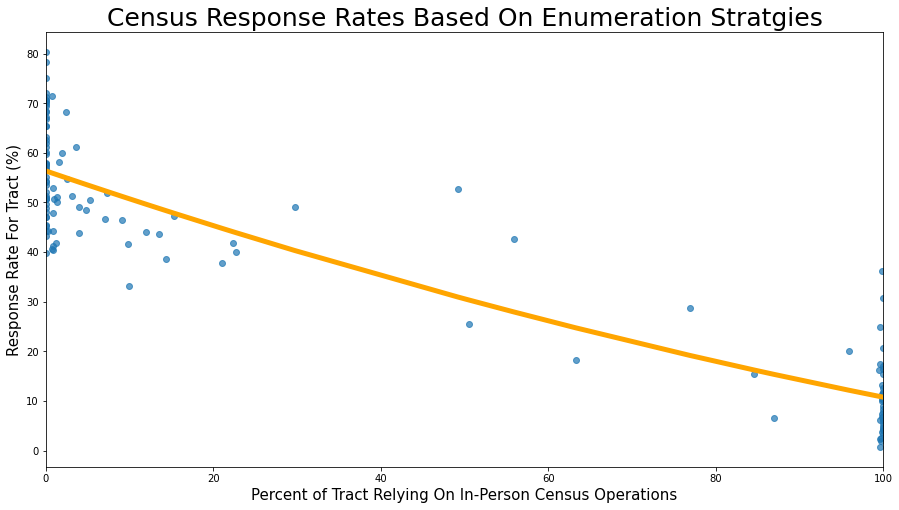

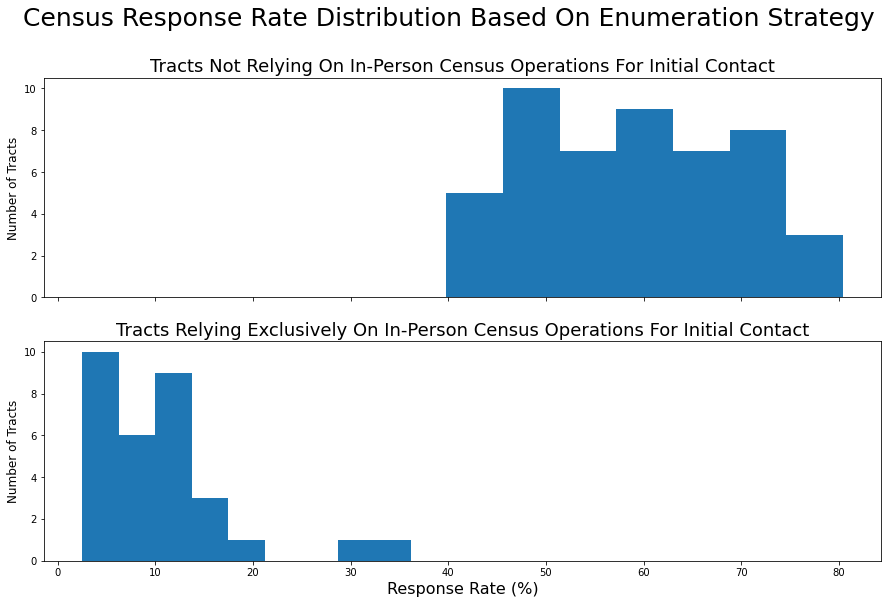

In [4]:
show_area('02')

### Montana

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.9
Tracts Relying On In-Person Census Operations For Initial Contact,-0.9


Total Number of Tracts Examined:  222


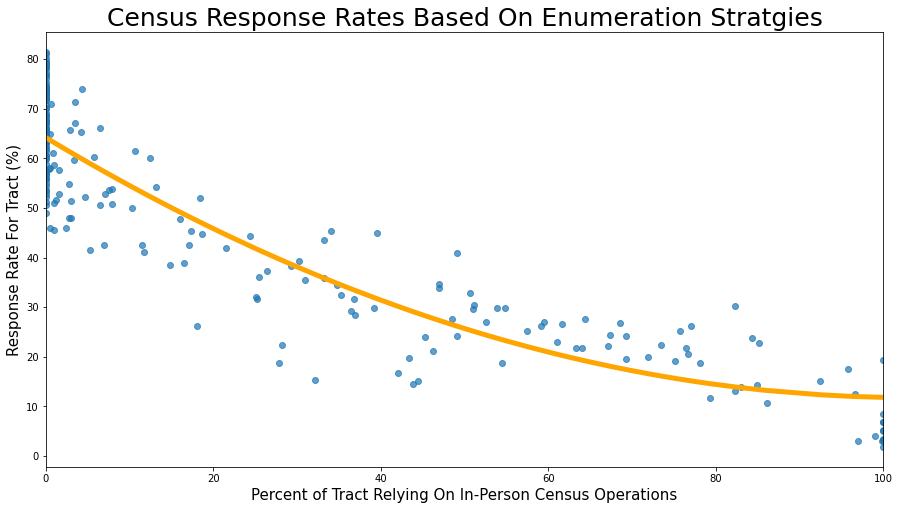

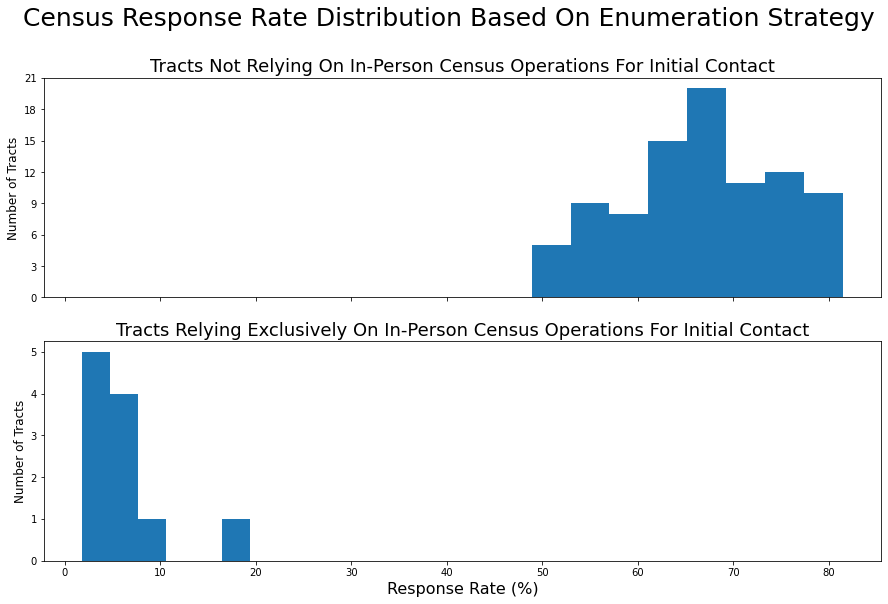

In [5]:
show_area(30)

### Texas

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.62
Tracts Relying On In-Person Census Operations For Initial Contact,-0.62


Total Number of Tracts Examined:  3793


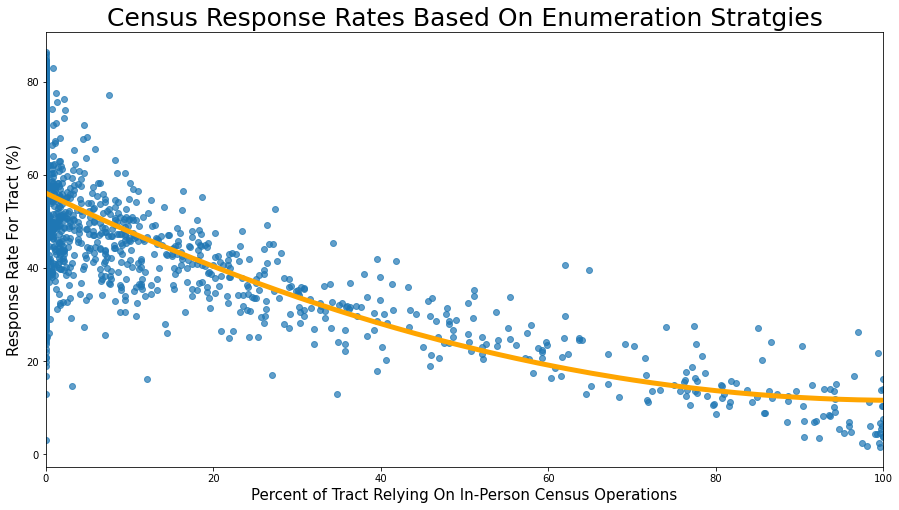

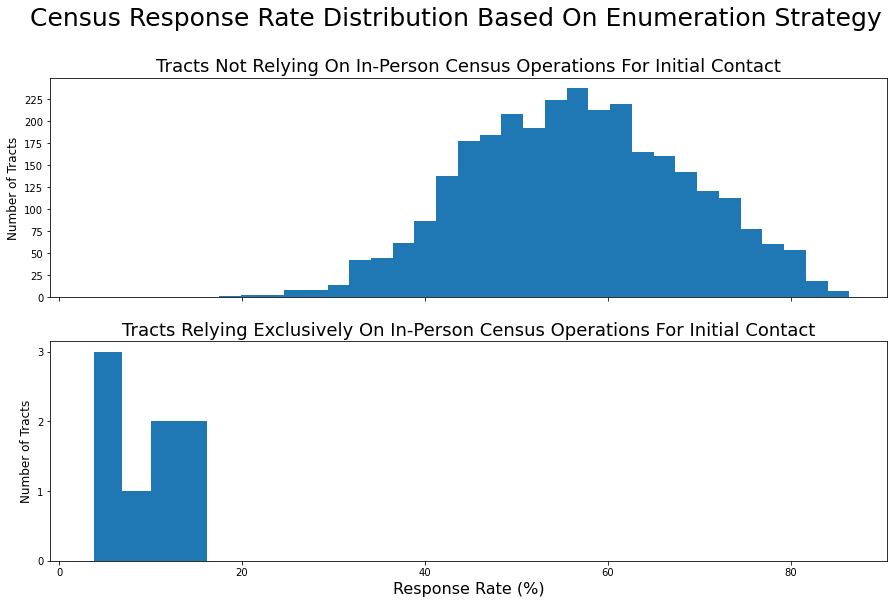

In [6]:
show_area(48)

### Maine

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.88
Tracts Relying On In-Person Census Operations For Initial Contact,-0.88


Total Number of Tracts Examined:  306


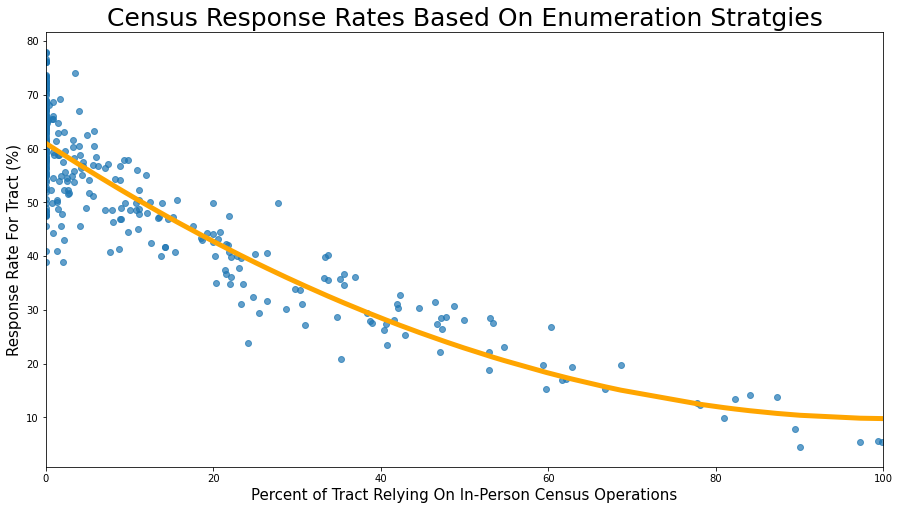

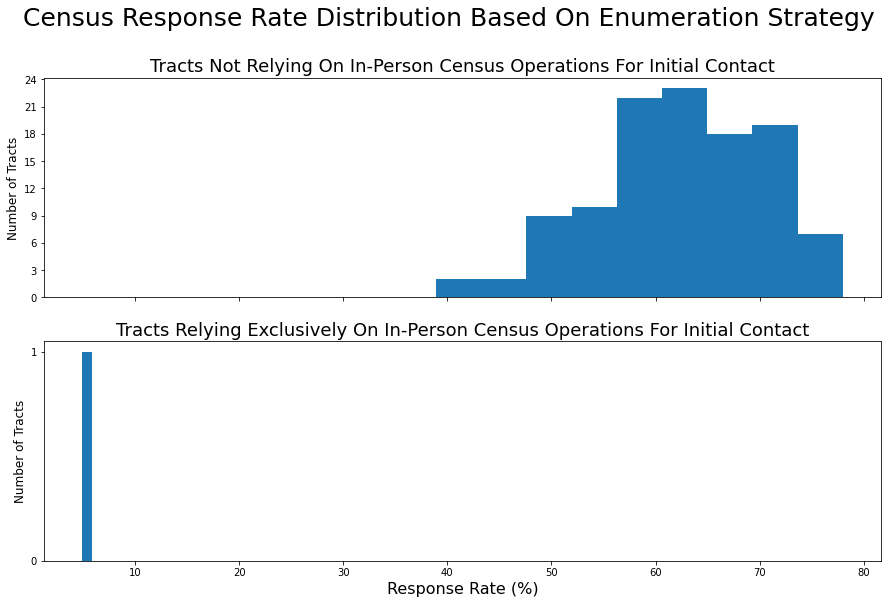

In [7]:
show_area(23)

### Colorado

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.72
Tracts Relying On In-Person Census Operations For Initial Contact,-0.72


Total Number of Tracts Examined:  1047


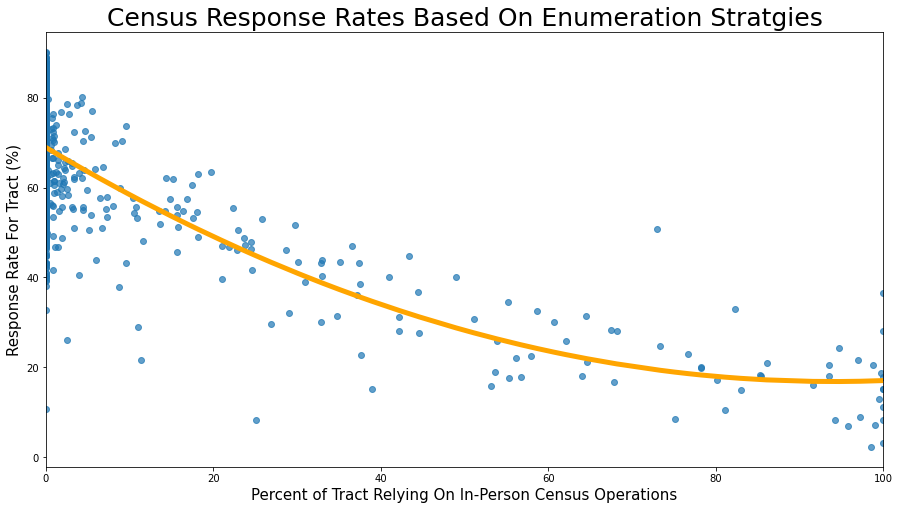

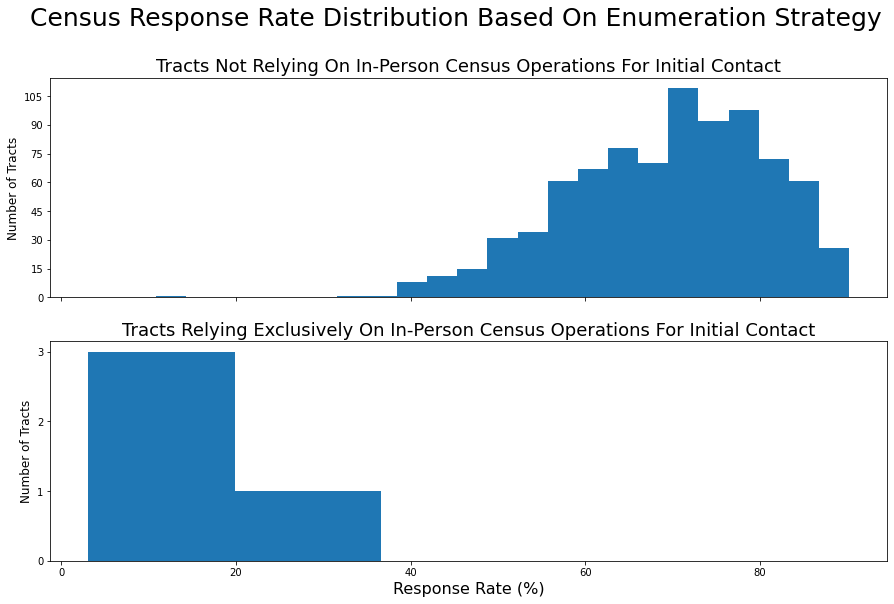

In [8]:
show_area('08')

### West Virginia

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.89
Tracts Relying On In-Person Census Operations For Initial Contact,-0.89


Total Number of Tracts Examined:  424


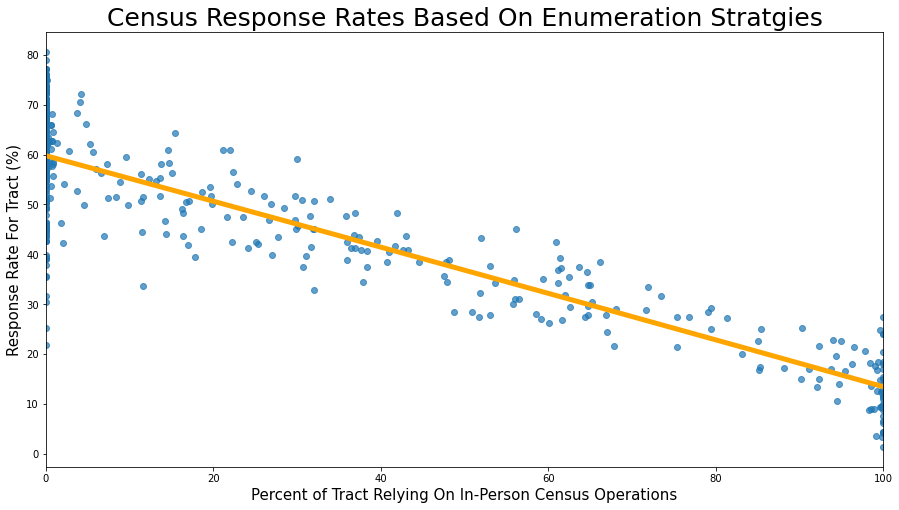

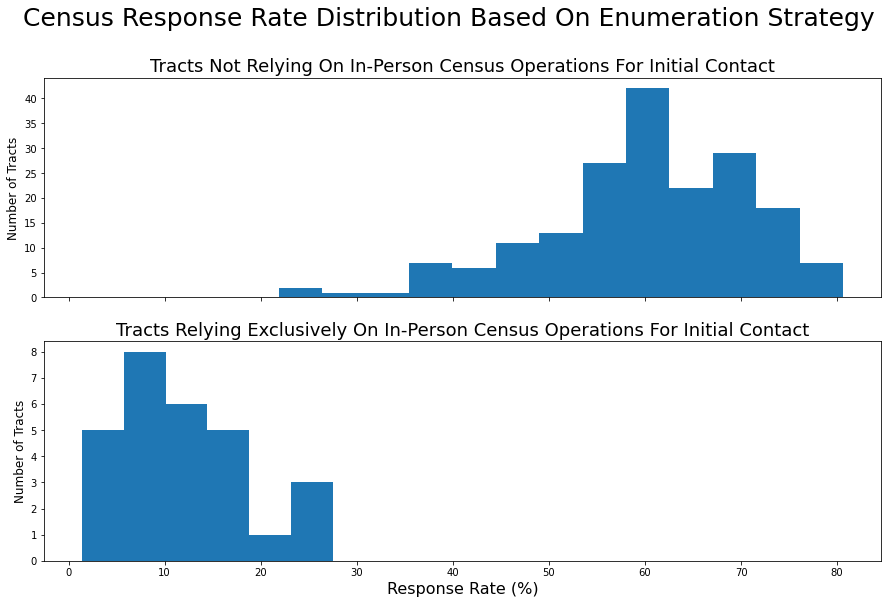

In [9]:
show_area(54)

### South Dakota

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.93
Tracts Relying On In-Person Census Operations For Initial Contact,-0.93


Total Number of Tracts Examined:  196


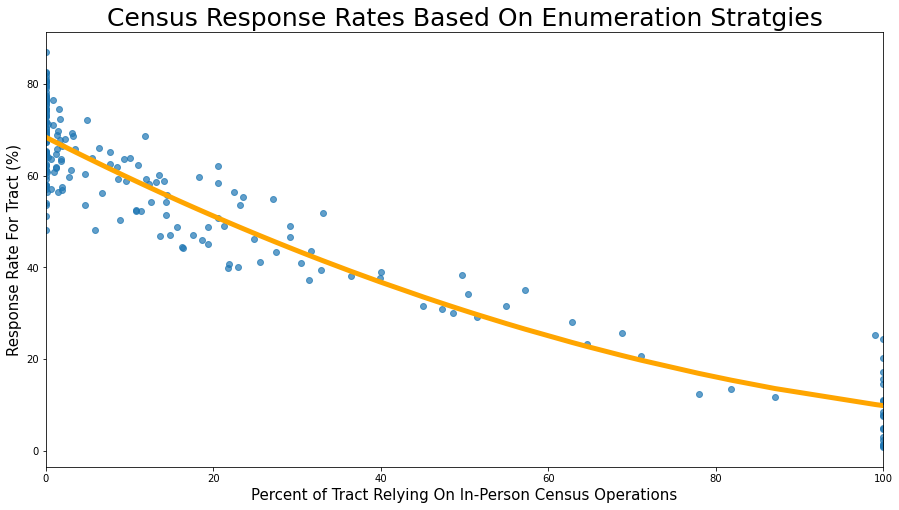

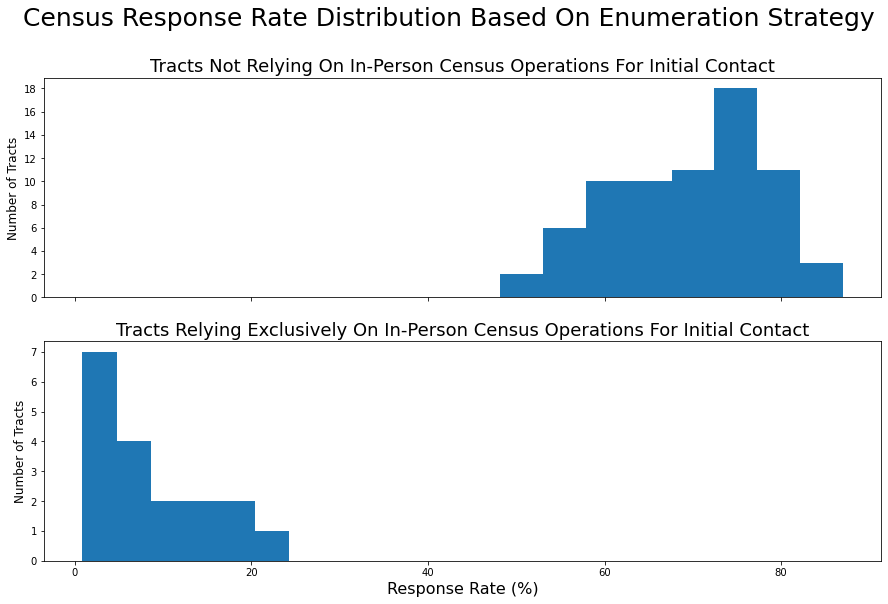

In [10]:
show_area(46)

### Idaho

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.85
Tracts Relying On In-Person Census Operations For Initial Contact,-0.85


Total Number of Tracts Examined:  194


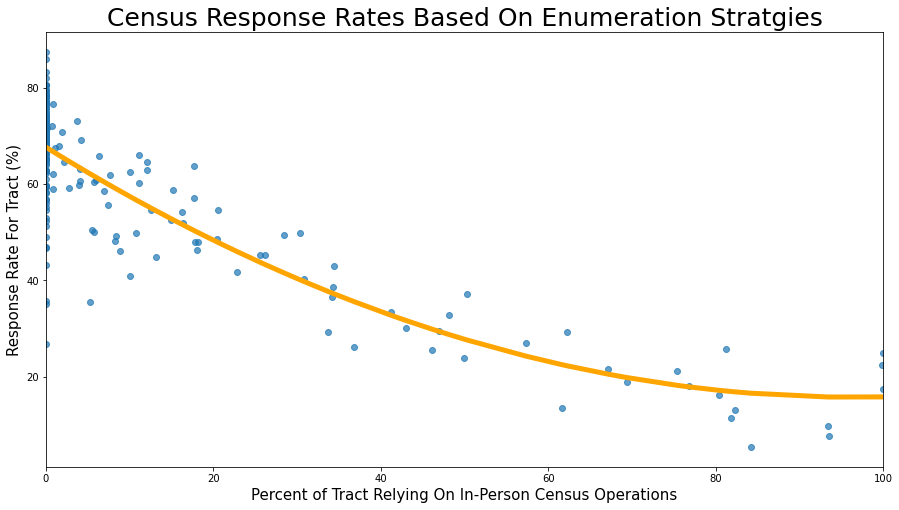

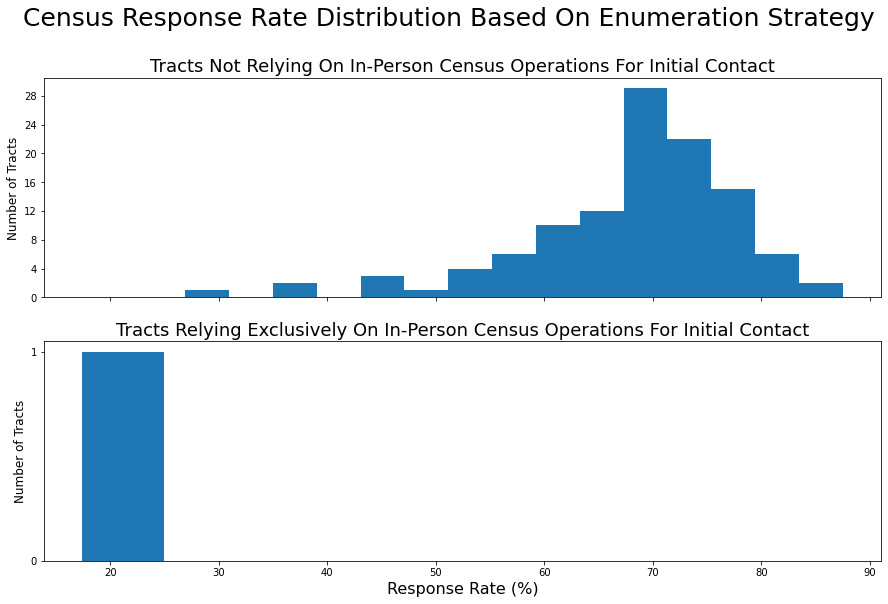

In [11]:
show_area(16)

### California

,Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operations For Initial Contact,0.5
Tracts Relying On In-Person Census Operations For Initial Contact,-0.5


Total Number of Tracts Examined:  6813


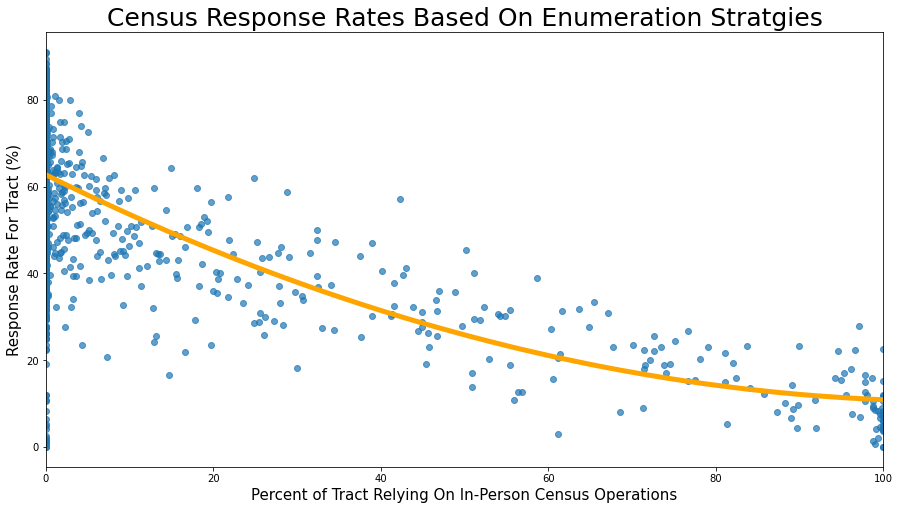

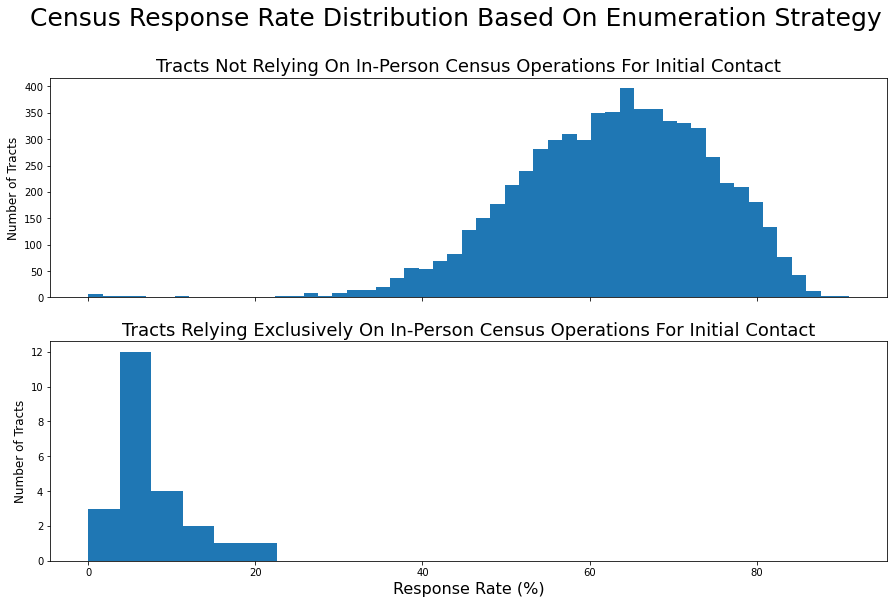

In [12]:
show_area('06')

### Other States

See the section below!

# Adapting This Analysis For Your Newsroom

*NewsCounts* can help you run this analysis for your state (or even county or multi-county region). It is *very* easy for us to pop out these same numbers for just about any level of US geography with a FIPS code. We can do it almost instantaneously - just ask!

We're also quite open to incorporating new data. There are thousands of data points we can add if you feel another demographic factor might be good for modeling why your region is getting undercounted. Drop us a note if you have an idea, and we'll make this work for you.

### Contact Info & Other Resources

Feel free to email me at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) or post on the *NewsCounts* Slack channel (email me for an invite) any time if you'd like us to do this for your area.

The Census Bureau is tracking 2020 response rates and provides [a wonderful map with up-to-date data](https://2020census.gov/en/response-rates.html). *NewsCounts* also provides a [beta dashboard](https://newscounts.appspot.com/) and [API](https://bernacho.github.io/NewsCounts-ResponseRatesAPI/API_documentation.html) that allows you to grab the daily response data for yourself. 

Please don't hesistate to reach out with any census reporting-related questions. We recognize this spring is a challenging time for journalists, and we're here to make covering this pivotal census easier for you.